In [18]:
import vtk
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [7]:

# plot two atlases to highlight common structure + count common structures
# goal is visualization so use vtk??

"""
class image_compare():
    def __init__(self, scrollable_img1, scrollable_img2):
"""  


class scrollable_image():
    def __init__(self, image_path, reader_type, z_slice, colour_window, colour_level):
        self.image_path = image_path
        self.reader_type = reader_type
        self.z_slice = z_slice
        self.colour_window = colour_window
        self.colour_level = colour_level

        # keep updated with obj at current step in pipeline
        # to allow pipeline steps to varry
        self.current_step = None

    def read_image(self):
        if self.reader_type == "DICOM":
            dicom_reader = vtk.vtkDICOMImageReader()
            dicom_reader.SetDirectoryName(self.image_path)
            self.reader = dicom_reader
        else:
            nifti_reader = vtk.vtkNIFTIImageReader()
            nifti_reader.SetFileName(self.image_path)
            self.reader = nifti_reader

        self.reader.Update()
        self.current_step = self.reader
    
    def resize_image(self, render_size):
        self.resizer = vtk.vtkImageResize()
        self.resizer.SetInputConnection(self.current_step.GetOutputPort())
        # gets original dimensions
        original_dims = np.asarray(self.resizer.GetOutput().GetDimensions())
        new_dims = list( original_dims*(render_size/original_dims[0:1].max()).astype(int))

        # adjusts output dimensions of the image
        self.resizer.SetOutputDimensions(*new_dims)
        self.resizer.Update()

        # scale zslice as well - doesn't seem needed rn???
        #self.z_slice = self.z_slice*(render_size/original_dims[0:1].max()).astype(int)

        self.current_step = self.resizer

    def map_image(self):
        self.mapper = vtk.vtkImageMapper()
        self.mapper.SetInputConnection(self.current_step.GetOutputPort())

        self.mapper.SetColorWindow(self.colour_window)
        self.mapper.SetColorLevel(self.colour_level)
        self.mapper.SetZSlice(self.z_slice)
        self.mapper.Update()

        self.current_step = self.mapper

    def add_colour_mapper(self, num_values):
        # create lookup table
        lut = vtk.vtkLookupTable()
        lut.SetNumberOfTableValues(num_values)
        lut.SetRange(0, num_values)
        lut.Build()

        color_series = vtk.vtkColorSeries()
        # choose the vtk colour scheme
        color_series.SetColorScheme(vtk.vtkColorSeries.BREWER_QUALITATIVE_SET3)

        # set intensity 0 to black
        lut.SetTableValue(0, 0, 0, 0, 1.0)

        # map the colour series into the lut - can't so automatically?
        num_colours_in_map = 12 # change to get len of the map
        for i in range(1,num_values):
            colour = color_series.GetColor(i % num_colours_in_map)
            # scale to proper colours
            lut.SetTableValue(i, colour.GetRed() / 255.0, colour.GetGreen() / 255.0, colour.GetBlue() / 255.0, 1.0)
        
        # TODO: map the common features to a disctinct set of colours

        self.colour_mapper = vtk.vtkImageMapToColors()
        self.colour_mapper.SetInputConnection(self.current_step.GetOutputPort())
        self.colour_mapper.SetLookupTable(lut)
        self.colour_mapper.PassAlphaToOutputOn()
        self.colour_mapper.Update()

        self.current_step = self.colour_mapper


    def add_actor(self):
        self.actor = vtk.vtkActor2D()
        self.actor.SetMapper(self.current_step)

    def add_text_actor(self):
        self.text_actor = vtk.vtkTextActor()
        self.text_actor.GetTextProperty().SetFontSize(24)
        self.text_actor.GetTextProperty().SetColor(1, 1, 1)
        self.text_actor.SetInput("Slice: " + str(self.z_slice))
    
    def set_text_position(self, pos_x, pos_y):
        self.text_actor.SetPosition(pos_x, pos_y)

    def create_mousewheel_callbacks(self):
    
        def scroll_forward(obj=None,event=None):
            self.z_slice = min(self.mapper.GetWholeZMax(), self.z_slice + 1)
            self.mapper.SetZSlice(self.z_slice)
            self.text_actor.SetInput("Slice: " + str(self.z_slice))

        def scroll_backward(obj=None,event=None):
            self.z_slice = max(self.mapper.GetWholeZMin(),self.mapper.GetZSlice() - 1)
            self.mapper.SetZSlice(self.z_slice)
            self.text_actor.SetInput("Slice: " + str(self.z_slice))
            
        return scroll_forward, scroll_backward

    def create_key_press_scroll(self):

        def key_press_scroll(obj, event):
            # Get the type of keypress
            key = obj.GetKeySym()
            
            if key == "Up":
                self.z_slice = min(self.mapper.GetWholeZMax(), self.z_slice + 1)
                self.mapper.SetZSlice(self.z_slice)
                self.text_actor.SetInput("Slice: " + str(self.z_slice))

            elif key == "Down":
                self.z_slice = max(self.mapper.GetWholeZMin(),self.mapper.GetZSlice() - 1)
                self.mapper.SetZSlice(self.z_slice)
                self.text_actor.SetInput("Slice: " + str(self.z_slice))
            self.window.Render()
        return key_press_scroll
    
    def set_render_window(self, window):
        self.window = window
    


In [17]:
# NOTE: the resampling of these labels should match the resampling of the 
# images to use for training!

human_labels_image_path = "./unprocessed_data/human/mni_icbm152_CerebrA_tal_nlin_sym_09c.nii"#"./atlases/human_labels_common.nii"
mouse_labels_image_path = "./unprocessed_data/mouse/labelsReformat.nii"#"./atlases/mouse_labels_common.nii"


reader_type = "NIFTY"
z_slice = 100
render_size_x =  410
render_size_y = 275
render_size = max(render_size_x, render_size_y)

human_labels_sitk = sitk.ReadImage(human_labels_image_path)
human_labels_np = sitk.GetArrayFromImage(human_labels_sitk)
human_labels_num_values = human_labels_np.max()

mouse_labels_sitk = sitk.ReadImage(mouse_labels_image_path)
mouse_labels_np = sitk.GetArrayFromImage(mouse_labels_sitk)
mouse_labels_num_values = mouse_labels_np.max()
num_values = max(human_labels_num_values, mouse_labels_num_values).astype(int)

min_intensity = 0
max_intensity = num_values
colour_window = max_intensity - min_intensity
colour_level = (min_intensity + max_intensity) / 2


mouse_labels = scrollable_image(mouse_labels_image_path, reader_type, z_slice, colour_window, colour_level)
mouse_labels.read_image()
mouse_labels.resize_image(render_size)
mouse_labels.add_colour_mapper(num_values)
mouse_labels.map_image()
mouse_labels.add_actor()
mouse_labels.add_text_actor()

human_labels = scrollable_image(human_labels_image_path, reader_type, z_slice, colour_window, colour_level)
human_labels.read_image()
human_labels.resize_image(render_size)
human_labels.add_colour_mapper(num_values)
human_labels.map_image()
human_labels.add_actor()
human_labels.add_text_actor()

actors = {
    "mouse": mouse_labels.actor,
    "human": human_labels.actor,
    "mouse_text": mouse_labels.text_actor,
    "human_text": human_labels.text_actor,
}

mappers = {
    "mouse": mouse_labels.mapper,
    "human": human_labels.mapper,
}

# define interactor and rendering
interactor = vtk.vtkRenderWindowInteractor()
renderer = vtk.vtkRenderer()
renderer.SetBackground(0, 0, 0) # make sure background is black

window = vtk.vtkRenderWindow()
actors["human"].GetPositionCoordinate().SetValue(render_size_x, 0) # add offset
window.SetSize(2*render_size_x, render_size_y)

# position the text TODO: make centered!!
mouse_labels.set_text_position(render_size_x/3, -3)
human_labels.set_text_position(render_size_x + render_size_x/8, -3)

window.AddRenderer(renderer)
interactor.SetRenderWindow(window)


fwd, bwd = mouse_labels.create_mousewheel_callbacks()
interactor.AddObserver('MouseWheelForwardEvent', fwd)
interactor.AddObserver('MouseWheelBackwardEvent', bwd)

kp = human_labels.create_key_press_scroll()
interactor.AddObserver("KeyPressEvent", kp)
# set render window to update on keypress
human_labels.set_render_window(window)

# Add actors to the renderer
for actor in actors.values():
    renderer.AddActor(actor)

# Display
window.Render()
interactor.SetInteractorStyle(vtk.vtkInteractorStyleTrackballCamera())  # Ensure proper interaction style
interactor.Initialize()
interactor.Start()

c:\Users\jessi\miniconda3\envs\mdsc689-03\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in long_scalars


### TODO:
- ~~add colour with a lookup table??~~
- add print statements to describe the image
- add changable colour level and window - with a slider???
- ~~print both side by side~~
- add printed info on commonalities
- ~~fix resize~~
- either circle the different intensities with thin black OR add more values!!
 
Other
- resize the images to be more comparable??? (choose best sizes that would make sense for training) [probs same?]
- ~~scroll the images separetly (can I split the window?? or scroll one with mouse and use keys for other) - **have to click??~~
- add colour to pandas dataframe to show comparision
- add in alternating the slice axis (fly thropugh)
 
Experiment
- use to compare to pick a first slice to train on???
 

Later
- add in 3D rendering

### Registration

<b>goal:</b> Want to align the mouse and human MRI images in a comparable space and align the atlas to each image both real and synthetic?
- same size (in which dimension) or to scale?
- same amount of padding

<b>solution:</b> use Nils' linear registration algorithm to align one of the atlases to the other, then linear transform each sample to that same space

Q - should I align to the higher or lower resolution??
- resample to higher: want better res for the image that has it, for detecting smaller structures
- resample to smaller: want lower computational cost, con lose detail from higher res image

A - for now resample to higher res image, then maybe change is seems like training with these are too computationally expensive

<b>Details of these data:</b>

- Mouse data dim: (193, 229, 193)
- Human data dim: (282, 548, 420)

mouse_labels_seg_mask: (420, 282, 548)
mouse_atlas: (420, 282, 548)
mouse_data_sample: (361, 257, 60)

human_labels_seg_mask: (193, 229, 193)
human_labels_seg_mask_alt: (193, 229, 193)
human_atlas: (129, 153, 128)
human_data_sample: (182, 218, 182)
human: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
mouse: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


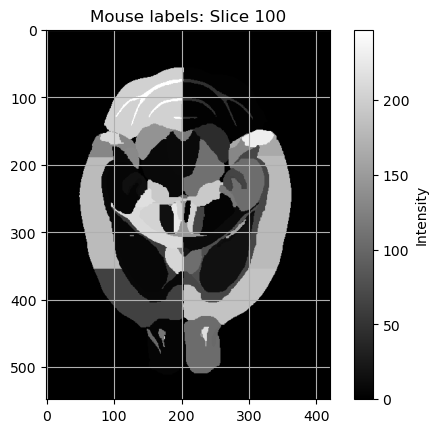

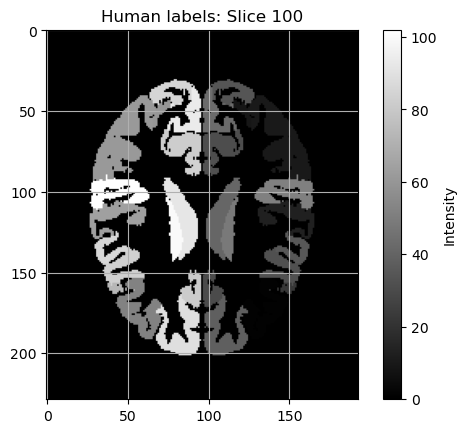

In [31]:
# Explore dim of atalses and data:
    # mouse_labels_seg_mask: (420, 282, 548)
    # mouse_atlas: (420, 282, 548)
    # mouse_data_sample: (361, 257, 60)

    # human_labels_seg_mask: (193, 229, 193)
    # human_labels_seg_mask_alt: (193, 229, 193)
    # human_atlas: (129, 153, 128)
    # human_data_sample: (182, 218, 182)


# next steps:
#   - plot to compare padding (on a grid with matplotlib)
#   - process the common atlas from the original data


mouse_labels_seg_mask = sitk.ReadImage("./unprocessed_data/mouse/labelsReformat.nii")
mouse_atlas = sitk.ReadImage("./unprocessed_data/mouse/atlasReformat.nii")
mouse_data_sample = sitk.ReadImage("./unprocessed_data/mouse/01sub.nii")


human_labels_seg_mask = sitk.ReadImage("./unprocessed_data/human/mni_icbm152_CerebrA_tal_nlin_sym_09c.nii")
human_labels_seg_mask_alt = sitk.ReadImage("./unprocessed_data/human/mni_icbm152_CerebrA_tal_nlin_sym_09c_maybe_diff.nii")
human_atlas = sitk.ReadImage("./unprocessed_data/human/atlas_resampled_bet.nii")
human_data_sample = sitk.ReadImage("./unprocessed_data/human/1020415.nii")


print("mouse_labels_seg_mask:", mouse_labels_seg_mask.GetSize())
print("mouse_atlas:", mouse_atlas.GetSize())
print("mouse_data_sample:", mouse_data_sample.GetSize())
print()
print("human_labels_seg_mask:", human_labels_seg_mask.GetSize())
print("human_labels_seg_mask_alt:", human_labels_seg_mask_alt.GetSize())
print("human_atlas:", human_atlas.GetSize())
print("human_data_sample:", human_data_sample.GetSize())


# reorient the mouse image
print("human:", human_labels_seg_mask.GetDirection()) #
print("mouse:", mouse_labels_seg_mask.GetDirection())

#mouse_labels_seg_mask = sitk.Flip(mouse_labels_seg_mask, [True, True, False])
mouse_labels_seg_mask = sitk.PermuteAxes(mouse_labels_seg_mask, [0, 2, 1])

mouse_labels_seg_mask_arr = sitk.GetArrayFromImage(mouse_labels_seg_mask)
mouse_labels_seg_mask_slice = mouse_labels_seg_mask_arr[z_slice, :, :]

plt.figure()
plt.imshow(mouse_labels_seg_mask_slice, cmap="gray") 
plt.colorbar(label="Intensity")
plt.title(f"Mouse labels: Slice {z_slice}")
plt.grid(True)
plt.show()

human_labels_seg_mask_arr = sitk.GetArrayFromImage(human_labels_seg_mask)
human_labels_seg_mask_slice = human_labels_seg_mask_arr[z_slice, :, :]

plt.figure()
plt.imshow(human_labels_seg_mask_slice, cmap="gray") 
plt.colorbar(label="Intensity")
plt.title(f"Human labels: Slice {z_slice}")
plt.grid(True)
plt.show()




### TODO Tonight:
- rotate the atlases
- resample the human atlas to mouse atlas size
- draft lose plan of how to register the images
- should achieve a more comparable plot

Start on comparison:
- highlight the comparable features (different coulours, list them, colour the df, etc.)
- count the number of comparable features
- select a slice for a first test!!!


### TODO Tommorrow (or later if tomorrow is for SNNs):
- set up altered registration pipeline??
- start first train
